In [3]:
import pandas as pd
import os
import sys
sys.path.append("/mnt/c/Users/ochapman/Documents/Mesirov/scRNA+ATAC/src")
from SingleCellExperiment import *

import plotly.graph_objects as go
import numpy as np
import scipy.stats
import math
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', None)


In [14]:
# how different are the genome and ecDNA backgrounds?
# Not very different
def gbg_vs_ebg(sample):
    if sample.lower() == 'rcmb56-ht':
        gbg=rcmb56ht()
        ebg=rcmb56ht_alt_bg()
    elif sample.lower() == 'rcmb56-pdx':
        gbg=rcmb56pdx()
        ebg=rcmb56pdx_alt_bg()
    else:
        raise ValueError("must be 'rcmb56-ht' or 'rcmb56-pdx'")
    
    labels = ['neither','ecDNA1','ecDNA2','both']
    ge_mat = np.zeros([len(labels),len(labels)])
    for i in gbg.df.index:
        if np.isnan(gbg.df.loc[i,'ecDNA1_status']):
            continue
        g_bits = 0
        if gbg.df.loc[i,'ecDNA1_status']:
            g_bits+=1
        if gbg.df.loc[i,'ecDNA2_status']:
            g_bits+=2
        e_bits = 0
        if ebg.df.loc[i,'ecDNA1_status']:
            e_bits+=1
        if ebg.df.loc[i,'ecDNA2_status']:
            e_bits+=2
        ge_mat[g_bits,e_bits]+=1
    # convert to sankey input
    s = []
    t = []
    v = []
    for i in range(len(labels)):
        for j in range(len(labels)):
            s.append(i)
            t.append(j+len(labels))
            v.append(ge_mat[i,j])
    # plot
    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(color = "black", width = 0.5),
          label = labels+labels
        ),
        link = dict(
          source = s, # indices correspond to labels, eg A1, A2, A1, B1, ...
          target = t,
          value = v
      ))])

    fig.update_layout(title_text="", font_size=10)
    fig.show()
    return ge_mat
arr = gbg_vs_ebg('rcmb56-pdx')
print(np.sum(arr))

10775.0


In [16]:
# how concordant are my classifications with copy-scAT?
# Low concordance.
def permutations_vs_copyscat(sample):
    if sample.lower() == 'rcmb56-ht':
        df=rcmb56ht().df
    elif sample.lower() == 'rcmb56-pdx':
        df=rcmb56pdx().df
    else:
        raise ValueError("must be 'rcmb56-ht' or 'rcmb56-pdx'")
    
    labels = ['neither','ecDNA1','ecDNA2','both','low-quality']
    mat = np.zeros([len(labels),len(labels)])
    for i in df.index:
        g_bits = 0
        if np.isnan(df.loc[i,'ecDNA1_status']):
            g_bits = 4
        else:
            if df.loc[i,'ecDNA1_status']:
                g_bits+=1
            if df.loc[i,'ecDNA2_status']:
                g_bits+=2
        e_bits = 0
        if np.isnan(df.loc[i,'cs_ecDNA1']):
            e_bits=4
        else:
            if df.loc[i,'cs_ecDNA1']:
                e_bits+=1
            if df.loc[i,'cs_ecDNA2&3']:
                e_bits+=2
        mat[g_bits,e_bits]+=1
    # convert to sankey input
    s = []
    t = []
    v = []
    for i in range(len(labels)):
        for j in range(len(labels)):
            s.append(i)
            t.append(j+len(labels))
            v.append(mat[i,j])
    # plot
    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(color = "black", width = 0.5),
          label = labels+labels
        ),
        link = dict(
          source = s, # indices correspond to labels, eg A1, A2, A1, B1, ...
          target = t,
          value = v
        ),
        #arrangement = 'fixed'
    )])

    fig.update_layout(title_text="", font_size=10)
    fig.show()
    return mat
arr = permutations_vs_copyscat('rcmb56-pdx')
print(np.sum(arr))

12869.0


In [ ]:
# How do the classifications distribute by seurat cluster?
# ht: cluster 5 enriched for both ecDNAs.
# pdx: cluster 16 enriched for neither.
def permutations_vs_seurat(sample):
    if sample.lower() == 'rcmb56-ht':
        df=rcmb56ht().df
    elif sample.lower() == 'rcmb56-pdx':
        df=rcmb56pdx().df
    else:
        raise ValueError("must be 'rcmb56-ht' or 'rcmb56-pdx'")
    
    labels = ['neither','ecDNA1','ecDNA2','both']
    clusters = list(range(len(df.seurat_cluster.dropna().unique())))
    mat = np.zeros([len(labels),len(clusters)])
    for i in df.index:
        g_bits = 0
        if np.isnan(df.loc[i,'ecDNA1_status']):
            continue
        else:
            if df.loc[i,'ecDNA1_status']:
                g_bits+=1
            if df.loc[i,'ecDNA2_status']:
                g_bits+=2
        if np.isnan(df.loc[i,'seurat_cluster']):
            continue
        else:
            e_bits = int(df.loc[i,'seurat_cluster'])
        mat[g_bits,e_bits]+=1
    # convert to sankey input
    s = []
    t = []
    v = []
    for i in range(len(labels)):
        for j in range(len(clusters)):
            s.append(i)
            t.append(j+len(labels))
            v.append(mat[i,j])
    # plot
    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(color = "black", width = 0.5),
          label = labels+clusters
        ),
        link = dict(
          source = s, # indices correspond to labels, eg A1, A2, A1, B1, ...
          target = t,
          value = v
        ),
        #arrangement = 'fixed'
    )])

    fig.update_layout(title_text="", font_size=10)
    fig.show()
    return pd.DataFrame(data=mat,index=labels,columns=clusters)
permutations_vs_seurat('rcmb56-pdx')

In [ ]:
# Samples positive in both
# ht: 84 cells. These look like ecDNA.
def tt(sample):
    if sample.lower() == 'rcmb56-ht':
        df=rcmb56ht().df
    elif sample.lower() == 'rcmb56-pdx':
        df=rcmb56pdx().df
    else:
        raise ValueError("must be 'rcmb56-ht' or 'rcmb56-pdx'")
    df=df.dropna(subset=['ecDNA1_status','cs_ecDNA1'])
    df = df[df['ecDNA1_status'] & df['cs_ecDNA1']]
    with open('tt.txt','w') as g:
        string = '\n'.join(df.index)+'\n'
        g.write(string)
    return string
# Samples positive by permutation test, but not by copyscat
# ht: 116 cells. With few exceptions, these also look ecDNA+.
def tf(sample):
    if sample.lower() == 'rcmb56-ht':
        df=rcmb56ht().df
    elif sample.lower() == 'rcmb56-pdx':
        df=rcmb56pdx().df
    else:
        raise ValueError("must be 'rcmb56-ht' or 'rcmb56-pdx'")
    df=df.dropna(subset=['ecDNA1_status','cs_ecDNA1'])
    df = df[df['ecDNA1_status'] & ~df['cs_ecDNA1']]
    with open('tf.txt','w') as g:
        string = '\n'.join(df.index)+'\n'
        g.write(string)
    return string
# Samples negative by permutation test, but positive by copyscat
# 11 cells. 2 with obvious ecDNA, ATTGCGCCATTGTGGC-1.bw and TGTTCCTCACCTCACC-1.bw
def ft(sample):
    if sample.lower() == 'rcmb56-ht':
        df=rcmb56ht().df
    elif sample.lower() == 'rcmb56-pdx':
        df=rcmb56pdx().df
    else:
        raise ValueError("must be 'rcmb56-ht' or 'rcmb56-pdx'")
    df=df.dropna(subset=['ecDNA1_status','cs_ecDNA1'])
    df = df[~df['ecDNA1_status'] & df['cs_ecDNA1']]
    with open('ft.txt','w') as g:
        string = '\n'.join(df.index)+'\n'
        g.write(string)
    return string
ft('rcmb56-ht')

In [ ]:
# Misclassified entries
df = rcmb56ht().df
misclassified = ['ATTGCGCCATTGTGGC-1','TGTTCCTCACCTCACC-1']
df=df.loc[misclassified]
df

In [ ]:
# Correlation with gene expression

# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = math.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    # calculate the effect size
    return (u1 - u2) / s
def mannwhitneyu_permutation_gene_expression(sample,gene):
    if sample.lower() == 'rcmb56-ht':
        df=rcmb56ht().df
    elif sample.lower() == 'rcmb56-pdx':
        df=rcmb56pdx().df
    else:
        raise ValueError("must be 'rcmb56-ht' or 'rcmb56-pdx'")
    if gene == 'DNTTIP2':
        ecDNA = 'ecDNA1'
    elif gene == 'KMT2E':
        ecDNA = 'ecDNA2'
    else:
        raise ValueError("must be 'DNTTIP2' or 'KMT2E'")
    df = df[df.qc_pass_seurat]
    p = df[ecDNA+'_status']
    gene_tbl="../2021-08-29_seurat/"+sample.lower()+"_"+gene.lower()+".sct.tsv"
    g = pd.read_csv(gene_tbl,sep='\t',index_col=1)
    g=g[gene]
    df = pd.concat([p,g],axis=1,join='inner')
    #plot = sns.displot(data=df,x=ecDNA+'_status',y=gene)
    ax = sns.boxplot(data=df,x=ecDNA+'_status',y=gene)
    #plot = sns.swarmplot(data=df,x=ecDNA+'_status',y=gene)
    #plt.set_axis_labels("log z-score "+ecDNA, "log "+gene+" expression")
    ax.set(xlabel=ecDNA+' status', ylabel= "scaled "+gene+" expression")
    #return df
    g1 = df[df[ecDNA+'_status']][gene].values
    g2 = df[df[ecDNA+'_status']==False][gene].values
    print("Cohen's d:",cohend(g1,g2))
    return scipy.stats.mannwhitneyu(g1,g2)
mannwhitneyu_permutation_gene_expression('rcmb56-ht','DNTTIP2')

In [ ]:
mannwhitneyu_permutation_gene_expression('rcmb56-ht','KMT2E')

In [ ]:
def mannwhitneyu_copyscat_gene_expression(sample,gene):
    if sample.lower() == 'rcmb56-ht':
        df=rcmb56ht().df
    elif sample.lower() == 'rcmb56-pdx':
        df=rcmb56pdx().df
    else:
        raise ValueError("must be 'rcmb56-ht' or 'rcmb56-pdx'")
    if gene == 'DNTTIP2':
        ecDNA = 'ecDNA1'
    elif gene == 'KMT2E':
        ecDNA = 'ecDNA2&3'
    else:
        raise ValueError("must be 'DNTTIP2' or 'KMT2E'")
    var='cs_'+ecDNA
    p = df[var].fillna(False)
    gene_tbl="../2021-08-29_seurat/"+sample.lower()+"_"+gene.lower()+".sct.tsv"
    g = pd.read_csv(gene_tbl,sep='\t',index_col=1)
    g=g[gene]
    df = pd.concat([p,g],axis=1,join='inner')
    #plot = sns.displot(data=df,x=ecDNA+'_status',y=gene)
    ax = sns.boxplot(data=df,x=var,y=gene)
    #plot = sns.swarmplot(data=df,x=ecDNA+'_status',y=gene)
    #plt.set_axis_labels("log z-score "+ecDNA, "log "+gene+" expression")
    ax.set(xlabel=ecDNA+' status', ylabel= "scaled "+gene+" expression")
    g1 = df[df[var]][gene].values
    g2 = df[df[var]==False][gene].values
    print("Cohen's d:",cohend(g1,g2))
    return scipy.stats.mannwhitneyu(g1,g2)
mannwhitneyu_copyscat_gene_expression('rcmb56-ht','DNTTIP2')

In [ ]:
mannwhitneyu_copyscat_gene_expression('rcmb56-ht','KMT2E')

In [ ]:
mannwhitneyu_permutation_gene_expression('rcmb56-pdx','DNTTIP2')

In [ ]:
mannwhitneyu_permutation_gene_expression('rcmb56-pdx','KMT2E')

In [ ]:
mannwhitneyu_copyscat_gene_expression('rcmb56-pdx','DNTTIP2')

In [ ]:
mannwhitneyu_copyscat_gene_expression('rcmb56-pdx','KMT2E')

(0.40179815915042905, 2.960220079984901e-116)

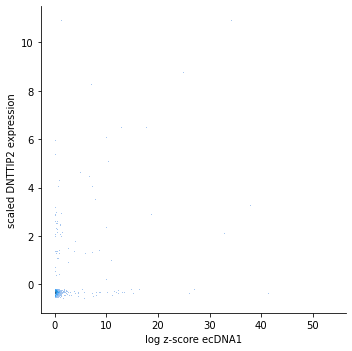

In [34]:
def pearsonr_permutation_gene_expression(sample,gene):
    if sample.lower() == 'rcmb56-ht':
        df=rcmb56ht().df
    elif sample.lower() == 'rcmb56-pdx':
        df=rcmb56pdx().df
    else:
        raise ValueError("must be 'rcmb56-ht' or 'rcmb56-pdx'")
    if gene == 'DNTTIP2':
        ecDNA = 'ecDNA1'
    elif gene == 'KMT2E':
        ecDNA = 'ecDNA2'
    else:
        raise ValueError("must be 'DNTTIP2' or 'KMT2E'")
    df = df[df.qc_pass_seurat]
    var=ecDNA+'_z-score'
    #p = np.log1p(df[var])
    p = df[var]
    q = df[ecDNA+'_status']
    gene_tbl="../2021-08-29_seurat/"+sample.lower()+"_"+gene.lower()+".sct.tsv"
    g = pd.read_csv(gene_tbl,sep='\t',index_col=1)
    g=g[gene]
    df = pd.concat([p,g,q],axis=1,join='inner')
    #df = np.log1p(df)
    plot = sns.displot(data=df,x=var,y=gene)#,hue=ecDNA+'_status')
    plot.set(xlabel="log z-score "+ecDNA, ylabel= "scaled "+gene+" expression")
    #plot.set_axis_labels("z-score "+ecDNA, "log "+gene+" expression")
    #return df
    return scipy.stats.pearsonr(df[var],df[gene])
pearsonr_permutation_gene_expression('rcmb56-ht','DNTTIP2')

(0.5377483498970776, 1.84106103529719e-223)

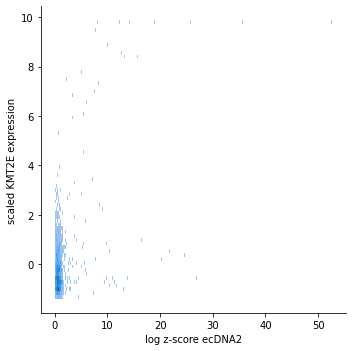

In [35]:
pearsonr_permutation_gene_expression('rcmb56-ht','KMT2E')

(0.5547124466873512, 0.0)

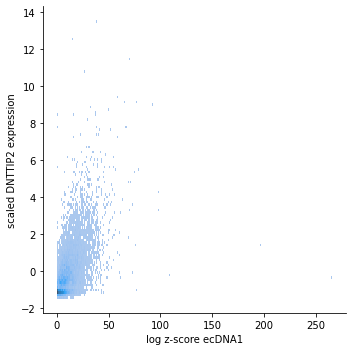

In [36]:
pearsonr_permutation_gene_expression('rcmb56-pdx','DNTTIP2')

(0.6848995874970196, 0.0)

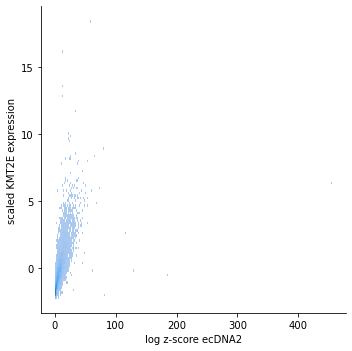

In [37]:
pearsonr_permutation_gene_expression('rcmb56-pdx','KMT2E')

# Scratch

In [ ]:
df = rcmb56pdx().df
df.sort_values('ecDNA2_z-score')

In [ ]:
rcmb56ht().df.loc['AAACATGCAGCTAACC-1','seurat_cluster']
df = rcmb56ht().df
df=df.dropna(subset=['ecDNA1_status','cs_ecDNA1'])
df[df['ecDNA1_status'] & df['cs_ecDNA1']]
with

In [ ]:
import argparse
import os
import sys
import pandas as pd
import pyranges as pr

In [ ]:
DATA_ROOT="/home/ochapman/expanse/projects/scRNA+ATAC"

TARGET_FILE=os.path.join(DATA_ROOT,'intervals','case11_ecDNA_2.hg38.bed')
FRAGMENTS_DIR=os.path.join(DATA_ROOT,'2021-10-18_fragments-tsv-gz','test')

In [ ]:
def sum_coverage(target_file,fragments_dir):
    d = {}
    target = pr.read_bed(target_file)
    for entry in os.scandir(fragments_dir):
        barcode = os.path.split(entry.path)[1]
        fragments_file = os.path.join(entry.path,barcode+'.bed')
        fragments = pr.read_bed(fragments_file)
        r=target.coverage(fragments)
        
        d[barcode]=sum(r.NumberOverlaps)
    barcodes,counts = zip(*d.items())
    return pd.DataFrame(counts,barcodes)

def coverage(target_file,fragments_dir):
    d = {}
    target = pr.read_bed(target_file)
    for entry in os.scandir(fragments_dir):
        barcode = os.path.split(entry.path)[1]
        #print(barcode)
        fragments_file = os.path.join(entry.path,barcode+'.bed')
        fragments = pr.read_bed(fragments_file)
        r=target.coverage(fragments)    
        i = (r.Chromosome.astype(str) + ':' + r.Start.astype(str) + '-' + r.End.astype(str)).values
        d[barcode]=pd.Series(r.NumberOverlaps.values,i)
    #print('convert to dataframe')
    barcodes,counts = zip(*d.items())
    return pd.DataFrame(counts,barcodes)

def count_overlaps(target_file,fragments_dir):
    grs = {}
    target = pr.read_bed(target_file)
    for entry in os.scandir(fragments_dir):
        barcode = os.path.split(entry.path)[1]
        fragments_file = os.path.join(entry.path, barcode+'.bed')
        grs[barcode] = pr.read_bed(fragments_file)
    r = pr.count_overlaps(grs,target)
    i = (r.Chromosome.astype(str) + ':' + r.Start.astype(str) + '-' + r.End.astype(str)).values
    return r.df.set_index(i).iloc[:,3:].transpose()

#r = coverage(TARGET_FILE,FRAGMENTS_DIR)
#r

r = count_overlaps(TARGET_FILE,FRAGMENTS_DIR)
r

In [ ]:
r.sum(axis=1)

In [ ]:
sum_coverage(TARGET_FILE,FRAGMENTS_DIR)

In [ ]:
r.set_index(r.Chromosome.astype(str) + ':' + r.Start.astype(str) + '-' + r.End.astype(str))

In [ ]:
r.to_csv


In [ ]:
r.NumberOverlaps.values